# Self-Driving Car Engineer Nanodegree


## Project 1 : **Finding Lane Lines on the Road** 
***

## a) Pipeline:

    1) Read/Upload the image to be processed.
    2) Conversion into Gray Scale (cv library).
    3) Canny Edge detection in order to higlight edges.
    4) Define a polynomial region of interest (where to find lane lines).
    5) Hough Transformation in order to identify points building a line.
    6) Line drawing
    7) Overlay of the two images (lines detected + original image).
    8) Output testing.

## 0) Setting and methods definition

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os, glob
import numpy as np
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import math

def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def gaussian_blur(image, kernel_size=5): 
    # Define a kernel size and apply Gaussian smoothing
    blur_gray = cv2.GaussianBlur(image,(kernel_size, kernel_size),0)
    return blur_gray
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def region_of_interest(gray_starting_image):
    
    # Region-of-interest vertices
    # Trapezoid shape, with bottom edge at the bottom of the image
    trap_bottom_width = 0.85  # width of bottom edge of trapezoid, expressed as percentage of image width
    trap_top_width = 0.07  # ditto for top edge of trapezoid
    trap_height = 0.4  # height of the trapezoid expressed as percentage of image height
    
    imshape = gray_starting_image.shape

    vertices = np.array([[\
		((imshape[1] * (1 - trap_bottom_width)) // 2, imshape[0]),\
		((imshape[1] * (1 - trap_top_width)) // 2, imshape[0] - imshape[0] * trap_height),\
		(imshape[1] - (imshape[1] * (1 - trap_top_width)) // 2, imshape[0] - imshape[0] * trap_height),\
		(imshape[1] - (imshape[1] * (1 - trap_bottom_width)) // 2, imshape[0])]]\
		, dtype=np.int32)
    
    # define extraction mask
    mask = np.zeros_like(gray_starting_image)
    cv2.fillPoly(mask, [vertices],255)
    # extract region of interest and return
    return cv2.bitwise_and(gray_starting_image, mask)
    
def hough_line_detect(img):
    # utilize probabilistic Hough line transform to detect lane lines  
    return cv2.HoughLinesP(edges, rho=1,theta=np.pi/180 , threshold=70,
                            minLineLength=60, maxLineGap=20)


def hough_transformation(masked_edges):
    """Applies the Hough transformation"""
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15   # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10  #minimum number of pixels making up a line
    max_line_gap = 20   # maximum gap in pixels between connectable line segments

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    hough_lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)
    return hough_lines

def draw_lines(original_image, image, hough_lines, color=[255, 0, 0], thickness=2):
    
    # Creating a blank to draw lines on
    line_image = np.copy(original_image)*0 
    
    # Iterate over the output "lines" and draw lines on the blank
    for line in hough_lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
        
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((image, image, image)) 

    # Draw the lines on the edge image
    lines_drawn = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
    
    return lines_drawn

def line_interpolation(image, lines, color=[255, 0, 0], thickness=10):

    # In case of error, don't draw the line(s)
    if lines is None:
        return
    if len(lines) == 0:
        return
    draw_right = True #Boolean: true will allow right line drawing
    draw_left = True  #Boolean: true will allow left line drawing

    # Find slopes of all lines
    # But only care about lines where abs(slope) > slope_threshold
    slope_threshold = 0.5
    slopes = []
    new_lines = []
    
    
    # Iterate over all the lines
    for line in lines:
        x1, y1, x2, y2 = line[0]  # line = [[x1, y1, x2, y2]]

        # Calculate slope
        if x2 - x1 == 0.:  # corner case, avoiding division by 0
            m = 999.  # practically infinite slope
        else:
            m = (y2 - y1) / (x2 - x1)
            
        # Filter lines based on slope
        if abs(m) > slope_threshold:
            slopes.append(m)
            new_lines.append(line)

    lines = new_lines
    
    # y = mx + b 
    # Left line --> m > 0
    # Right line --> m < 0
    # Line are placed on the right/left half of the image
    
    right_lines = []
    left_lines = []
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        img_x_center = image.shape[1] / 2  # x coordinate of center of image
        if slopes[i] > 0 and x1 > img_x_center and x2 > img_x_center:
            right_lines.append(line)
        elif slopes[i] < 0 and x1 < img_x_center and x2 < img_x_center:
            left_lines.append(line)
            
    # Run linear regression to find best fit line for right and left lane lines
    # Right lane lines
    right_lines_x = []
    right_lines_y = []
    
    for line in right_lines:
        x1, y1, x2, y2 = line[0]
        
        right_lines_x.append(x1)
        right_lines_x.append(x2)
        
        right_lines_y.append(y1)
        right_lines_y.append(y2)
        
    if len(right_lines_x) > 0:
        right_m, right_b = np.polyfit(right_lines_x, right_lines_y, 1)  # y = mx + b
    else:
        right_m, right_b = 1, 1
        draw_right = False

    # Left lane lines
    left_lines_x = []
    left_lines_y = []
    
    for line in left_lines:
        x1, y1, x2, y2 = line[0]
        
        left_lines_x.append(x1)
        left_lines_x.append(x2)
            
        left_lines_y.append(y1)
        left_lines_y.append(y2)

    if len(left_lines_x) > 0:
        left_m, left_b = np.polyfit(left_lines_x, left_lines_y, 1)  # y = mx + b
    else:
        left_m, left_b = 1, 1
        draw_left = False
    
    # Find 2 end points for right and left lines, used for drawing the line
    # y = m*x + b --> x = (y - b)/m
    
    trap_height = 0.4  # height of the trapezoid expressed as percentage of image height
    
    y1 = image.shape[0]
    y2 = image.shape[0] * (1 - trap_height) #Bottom 60% of the image
    
    right_x1 = (y1 - right_b) / right_m #x = (y - b)/m
    right_x2 = (y2 - right_b) / right_m #x = (y - b)/m
    
    left_x1 = (y1 - left_b) / left_m #x = (y - b)/m
    left_x2 = (y2 - left_b) / left_m #x = (y - b)/m
    
    # Convert calculated end points from float to int
    y1 = int(y1)
    y2 = int(y2)
    right_x1 = int(right_x1)
    right_x2 = int(right_x2)
    left_x1 = int(left_x1)
    left_x2 = int(left_x2)

    # Draw the right and left lines on image
    if draw_right:
        cv2.line(image, (right_x1, y1), (right_x2, y2), color, thickness)
    if draw_left:
        cv2.line(image, (left_x1, y1), (left_x2, y2), color, thickness)

def overlay_images(starting_image, image_line, α=0.8, β=1., γ=0.):
    
    #Overlay the two images
    output_image = cv2.addWeighted(starting_image, α, image_line, β, γ)
    return output_image

def image_pipeline(starting_image):
    
    #Image processing pipeline
    gray_starting_image = grayscale(starting_image)
    blur_gray = gaussian_blur(gray_starting_image, kernel_size)
    edges_image = canny(blur_gray, low_threshold, high_threshold)
    masked_edges = region_of_interest(edges_image)
    hough_lines = hough_transformation(masked_edges)
    line_img = np.zeros((*gray_starting_image.shape, 3), dtype=np.uint8)  # 3-channel RGB image
    line_interpolation(line_img, hough_lines)
    output_image = overlay_images(starting_image, line_img)
    return output_image
    

## 1) Read in an Image

Read an image containing white lines.

This image is: Starting image


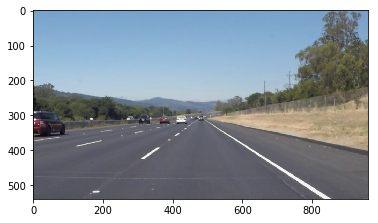

In [2]:
#reading in an image
starting_image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is: Starting image')
plt.imshow(starting_image)

## 2) Conversion into Gray Scale (cv library).

Convert a colored image into a gray one

This image is: Gray image


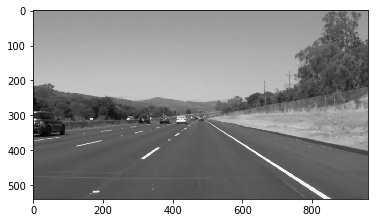

In [3]:
gray_starting_image = grayscale(starting_image)
print('This image is: Gray image')
plt.imshow(gray_starting_image, cmap='gray')

## 3) Canny Edge detection in order to higlight edges.

Find the line boundaries.

This image is: Edge detected


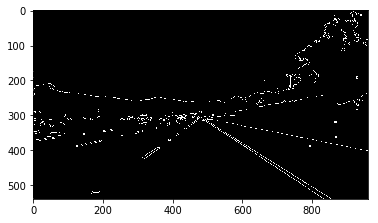

In [4]:
#Gaussian smoothing
kernel_size = 5
blur_gray = gaussian_blur(gray_starting_image, kernel_size)

#Canny edge detection
low_threshold = 50
high_threshold = 150
edges_image = canny(blur_gray, low_threshold, high_threshold)
print('This image is: Edge detected')
plt.imshow(edges_image, cmap='gray')

## 4) Define a polynomial region of interest (where to find lane lines).

Mask the image higlighting the region of interest.

This image is: Edge masked


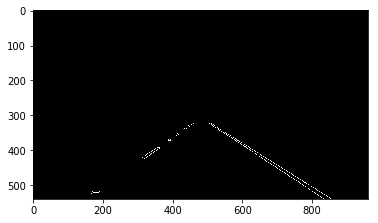

In [5]:
masked_edges = region_of_interest(edges_image)

#Print the image
print('This image is: Edge masked')
plt.imshow(masked_edges, cmap='gray')

## 5) Hough Transformation in order to identify points building a line.

Apply Hough transformation in order to create the line connecting all the line pixel

This image is: Hough Transformed with line


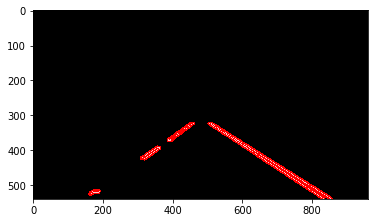

In [6]:
hough_lines = hough_transformation(masked_edges)

hough_transformed = draw_lines(starting_image, masked_edges, hough_lines)

#Print the image
print('This image is: Hough Transformed with line')
plt.imshow(hough_transformed, cmap='gray')

## 6) Line drawing

Average/extrapolate the line segments detected to map out the fullextent of the lane

This image is: Lines drawn


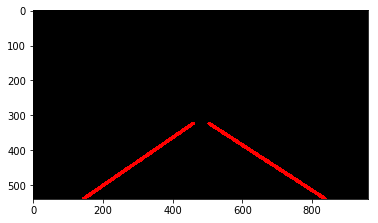

In [7]:
line_img = np.zeros((*gray_starting_image.shape, 3), dtype=np.uint8)  # 3-channel RGB image
line_interpolation(line_img, hough_lines)

#Print the image
print('This image is: Lines drawn')
plt.imshow(line_img)

## 7) Overlay of the two images (lines detected + original image)

Average/extrapolate the line segments detected to map out the fullextent of the lane

This image is: Lines drawn


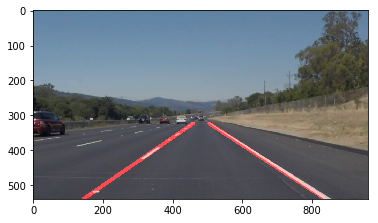

In [8]:
# overlay the empty image with the lines unto the original image with some alpha transparency

overlayed_image = overlay_images(starting_image, line_img)

#Print the image
print('This image is: Lines drawn')
plt.imshow(overlayed_image)

## 8) Output testing

##    a) Pipeline

This image is: Lines drawn


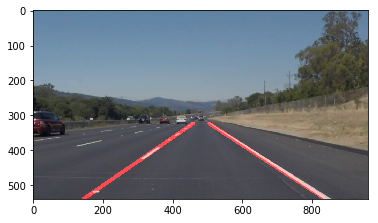

In [9]:
output_image = image_pipeline(starting_image)

#Print the image
print('This image is: Lines drawn')
plt.imshow(output_image)

##    b) White Right

In [10]:
white_output = 'test_videos_output/white_output.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/white_output.mp4
[MoviePy] Writing video test_videos_output/white_output.mp4


100%|█████████▉| 221/222 [00:13<00:00, 16.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/white_output.mp4 

CPU times: user 2.83 s, sys: 238 ms, total: 3.07 s
Wall time: 15.3 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./test_videos_output/white_output.mp4'))

##    c) Yellow Left

In [12]:
yellow_output = 'test_videos_output/yellow_output.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(image_pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/yellow_output.mp4
[MoviePy] Writing video test_videos_output/yellow_output.mp4


100%|█████████▉| 681/682 [00:46<00:00, 14.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/yellow_output.mp4 

CPU times: user 8.96 s, sys: 712 ms, total: 9.67 s
Wall time: 48.2 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./test_videos_output/yellow_output.mp4'))

##    d) Challenge

In [14]:
challenge_output = 'test_videos_output/challenge_output.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(image_pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_output.mp4
[MoviePy] Writing video test_videos_output/challenge_output.mp4


100%|██████████| 251/251 [00:34<00:00,  7.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_output.mp4 

CPU times: user 5.98 s, sys: 430 ms, total: 6.41 s
Wall time: 37.7 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./test_videos_output/challenge_output.mp4'))